# Evaluation

## Load Package

In [1]:
import os
import re
import json
import torch
import spacy
import argparse
import numpy as np  # numpy==1.23.5
from tqdm import tqdm
from thefuzz import fuzz
from collections import defaultdict
from fairseq.data.dictionary import Dictionary  # fairseq == 0.6.1
from fairseq import data, tasks, utils, tokenizer
from fairseq.sequence_scorer import SequenceScorer
from spacy.lang.en.stop_words import STOP_WORDS
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from _api_key import get_openai_api_key

## Basic Function

In [2]:
def load_json_file(file_path):
    """
    Load json file
    """
    with open(file_path,'r',encoding='utf-8') as f:
        file = json.load(f)
        f.close()
    return file

def save_json_file(file, file_path, sort_keys:bool=False):
    """
    Save json file
    """
    with open(file_path,'w',encoding='utf-8') as f:
        json.dump(file, f, indent=4, ensure_ascii=False, sort_keys=sort_keys)
        f.close()

In [3]:
def splitDataset(file, puntype='hom'):
    """
    Enter path or json file to separate the pun part from the non-pun part of the dataset
    """
    if isinstance(file,str):
        dataset = load_json_file(file)
    else:
        dataset = file
    punDataset = dict()
    nonpunDataset = dict()
    for ID in dataset:
        data = dataset[ID]
        if puntype in ID:
            if data.get('pun_word', False):
                punDataset[ID] = data
            else:
                nonpunDataset[ID] = data
    return punDataset, nonpunDataset

In [4]:
def tokenize(text:str, lemma:bool=False, filter:bool=False, lower:bool=True):
    """
    Tokenize the input text
    """
    def is_content(word, tag):
        # Determine whether it is a content word
        if not word in STOP_WORDS and \
           (tag.startswith('NN') or tag.startswith('VB') or tag.startswith('JJ')):
            return True
        return False
    nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
    tokens = nlp(text)
    if lemma:
        if filter:
            tokens = [token.lemma_ for token in tokens if is_content(token.lemma_, token.tag_)]
        else:
            tokens = [token.lemma_ for token in tokens]
    else:
        if filter:
            tokens = [token.text for token in tokens if is_content(token.text, token.tag_)]
        else:
            tokens = [token.text for token in tokens]
    if lower:
        tokens = [token.lower() for token in tokens]
    return tokens

## Pre-defined Class

In [5]:
class Glove:
    """
    Glove Model
    """
    def __init__(self, idx_to_token, idx_to_vec, use_cuda):
        """
        Define the class of Glove model
        :param idx_to_token: vocabulary
        :param idx_to_vec: embedding vector
        """
        self.idx_to_token = idx_to_token
        self.idx_to_vec = idx_to_vec
        self.unknown_idx = 0
        self.token_to_idx = {token:idx for idx,token in enumerate(self.idx_to_token)}
        if use_cuda:
            self.idx_to_vec = self.idx_to_vec.cuda()

    @classmethod
    def load_model(cls, model_path:str, cpu=False):
        idx_to_token, idx_to_vec = ['<unk>'], []
        with open(model_path, 'r', encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, vec = elems[0], [float(e) for e in elems[1:]]
                if len(vec) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(vec)
        idx_to_vec = [[0]*len(idx_to_vec[0])] + idx_to_vec
        use_cuda = torch.cuda.is_available() and not cpu
        return cls(idx_to_token, torch.tensor(idx_to_vec), use_cuda)

    def cosine_similarity(self, words1, words2):
        vec1 = self.__getitem__(words1)
        vec2 = self.__getitem__(words2)
        vec1 = vec1.unsqueeze(0) if len(vec1.shape)==1 else vec1
        vec2 = vec2.unsqueeze(0) if len(vec2.shape)==1 else vec2
        cos = torch.matmul(vec1,vec2.T) / ((torch.sqrt(torch.sum(vec1*vec1,dim=1,keepdim=True))+1e-9) *
                                           (torch.sqrt(torch.sum(vec2*vec2,dim=1,keepdim=True)).T+1e-9))
        return cos.data.cpu().numpy()

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token,self.unknown_idx) for token in tokens] \
            if isinstance(tokens, list) else self.token_to_idx.get(tokens, self.unknown_idx)
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)


class SkipGram(object):
    """
    SkipGram model used in previous papers
    """
    def __init__(self, model, vocab, use_cuda):
        self.vocab = vocab
        self.ivectors = model['embedding.ivectors.weight'].detach()
        self.ovectors = model['embedding.ovectors.weight'].detach()
        assert len(self.vocab) == self.ivectors.shape[0]
        if use_cuda:
            self.ivectors = self.ivectors.cuda()
            self.ovectors = self.ovectors.cuda()

    @classmethod
    def load_model(cls, model_path, vocab_path, cpu=False):
        model = torch.load(model_path)
        vocab = Dictionary.load(vocab_path)
        use_cuda = torch.cuda.is_available() and not cpu
        return cls(model, vocab, use_cuda)

    def score(self, iwords, owords):
        """p(oword | iword)
        """
        iwords = torch.LongTensor([self.vocab.index(w) for w in iwords])
        owords = torch.LongTensor([self.vocab.index(w) for w in owords])
        ivectors = self.ivectors[iwords]
        ovectors = self.ovectors[owords]
        scores = torch.matmul(ovectors, ivectors.t())
        probs = scores.sigmoid()
        return probs.data.cpu().numpy()


class UniGram(object):
    """
    Unigram model used in previous papers
    """
    def __init__(self, word_counts, oov_prob):
        self.word_counts = word_counts
        self.total_count = sum(self.word_counts.values())
        self.oov_prob = oov_prob
        self._oov_smoothing_prob = self.oov_prob * (1. / self.total_count)

    @classmethod
    def load_model(cls, dict_path, oov_prob=0.03):
        word_counts = {}
        with open(dict_path, 'r', encoding='utf-8') as f:
            for line in f:
                item = line.strip().split()
                word_counts[item[0]] = int(item[1])
        return cls(word_counts, oov_prob)

    def _freq(self, token):
        p = self.word_counts.get(token, 0) / float(self.total_count)
        smoothed_p = (1 - self.oov_prob) * p + self._oov_smoothing_prob
        return smoothed_p

    def freq(self, tokens):
        if isinstance(tokens, list):
            return [self._freq(token) for token in tokens]
        else:
            return self._freq(tokens)


class LM(object):
    """
    wiki103_fconv_lm used in previous papers
    """
    def __init__(self, task, scorer, use_cuda):
        self.task = task
        self.scorer = scorer
        self.use_cuda = use_cuda
        if use_cuda:
            self.scorer.cuda()

    @classmethod
    def load_model(cls, model_path, cpu=False):
        args = argparse.Namespace(data=os.path.dirname(model_path), path=model_path, cpu=cpu, task='language_modeling',
                output_dictionary_size=-1, self_target=False, future_target=False, past_target=False)
        use_cuda = torch.cuda.is_available() and not cpu
        task = tasks.setup_task(args)
        models, _ = utils.load_ensemble_for_inference([args.path], task = task)
        d = task.target_dictionary
        scorer = SequenceScorer(models, d)
        return cls(task, scorer, use_cuda)

    def score_sents(self, sents, tokenize=str.split):
        """Return log p at each word
        """
        itr = self.make_batches(sents, self.task.target_dictionary, self.scorer.models[0].max_positions(), tokenize=tokenize)
        results = self.scorer.score_batched_itr(itr, cuda=self.use_cuda)
        scores = []
        for id_, src_tokens, __, hypos in results:
            pos_scores = hypos[0]['positional_scores'].data.cpu().numpy()
            scores.append((int(id_.data.cpu().numpy()), pos_scores))
        # sort by id
        scores = [s[1] for s in sorted(scores, key=lambda x: x[0])]
        return scores

    def make_batches(self, lines, src_dict, max_positions, tokenize=str.split):
        tokens = [
            tokenizer.Tokenizer.tokenize(src_str, src_dict, add_if_not_exist=False, tokenize=tokenize).long()
            for src_str in lines
        ]
        lengths = np.array([t.numel() for t in tokens])
        # Load dataset
        # MonolingualDataset[i] = source, future_target, past_target
        # all targets are effectively ignored during inference
        dataset = data.MonolingualDataset(
                dataset=[(s[:-1], s[1:], None) for s in tokens],
                sizes=lengths, src_vocab=src_dict, tgt_vocab=src_dict,
                add_eos_for_other_targets=False, shuffle=False)
        itr = self.task.get_batch_iterator(
            dataset=dataset,
            max_tokens=100,
            max_sentences=5,
            max_positions=max_positions,
        ).next_epoch_itr(shuffle=False)
        return itr

In [6]:
class GenerationScorer:
    """
    Calculate indicators like Ambiguity, Distinctiveness, Surprise and Unusualness  \n
    The word embedding model used for some indicators is relatively old, and it is necessary to ensure that pun word and alternative word exist in the vocab dictionary for the indicators to be meaningful
    """
    def __init__(self, embedding: SkipGram | Glove, unigram: UniGram, lm: LM):
        self.embedding = embedding
        self.unigram = unigram
        self.lm = lm

        self.words = None
        self.content_words = None
        self.punchline = None
        self.pun_ind = None
        self.pun_word = None
        self.alter_word = None
        self.meanings = None

        self.unigram_logprobs = None
        self.unigram_probs = None
        self.embedding_scores = None
        self.meaning_logprior = None
        self.valid = None

    def change(self, text, meanings, pun_ind:int=None):
        self.words = tokenize(text, lower=False)
        self.content_words = tokenize(text, lemma=True, filter=True)
        self.punchline = meanings[0]
        if pun_ind is None:
            self.pun_ind = self.fuzz_matching_index(self.punchline, self.words)
        else:
            self.pun_ind = pun_ind
        self.pun_word, self.alter_word = meanings[1:3]
        self.meanings = [tokenize(self.pun_word, lemma=True)[0],
                         tokenize(self.alter_word, lemma=True)[0]]

        _words = list(set(self.content_words + self.meanings))
        self.unigram_probs = {w: self._unigram_probs(w) for w in _words}
        self.unigram_logprobs = {w: np.log(p) for w, p in self.unigram_probs.items()}
        self.embedding_scores = self._embedding_scores(_words, self.meanings)
        self.meaning_logprior = self._meaning_logprior()
        self.valid = True
        # If pun_word, alter_word is not in the dictionary of the embedding model, then the indicator is not valid
        if isinstance(self.embedding, SkipGram):
            unk_ind = self.embedding.vocab.unk()
            if unk_ind in [self.embedding.vocab.index(m) for m in self.meanings]:
                self.valid = False
        else:
            unk_ind = self.embedding.unknown_idx
            if unk_ind in [self.embedding.token_to_idx[m] for m in self.meanings]:
                self.valid = False
        # print(self.words)
        # print(self.content_words)
        # print(self.punchline, self.meanings)
        # print(self.pun_ind)

    def fuzz_matching_index(self, targets:str|list, candidates:list):
        # Find the best fuzz match
        if isinstance(targets,str):
            targets = [targets]
        inds = []
        for target in targets:
            scores = [fuzz.ratio(cand,target)/100 for cand in candidates]
            try:
                ind = scores.index(max(scores))
            except:
                ind = -1
            inds.append(ind)
        return max(inds)

    def _unigram_probs(self, w):
        uni_probs = self.unigram.freq(w)
        return uni_probs

    def _glove_scores(self, w, m):
        scores = defaultdict(dict)
        _scores = self.embedding.cosine_similarity(w, m)
        mean = np.mean(_scores, axis=0, keepdims=True)
        std = np.std(_scores, axis=0, keepdims=True)
        _scores = (_scores - mean) / std
        for i, wi in enumerate(w):
            for j, mj in enumerate(m):
                scores[wi][mj] = np.exp(_scores[i][j] + self.unigram_logprobs[wi])
        return scores

    def _skipgram_scores(self, w, m):
        scores = defaultdict(dict)
        _scores = self.embedding.score(iwords=m, owords=w)  # p(oword | iword)
        for i, wi in enumerate(w):
            for j, mj in enumerate(m):
                scores[wi][mj] = _scores[i][j]
        return scores

    def _embedding_scores(self, w, m):
        if isinstance(self.embedding, SkipGram):
            return self._skipgram_scores(w,m)
        else:
            return self._glove_scores(w,m)

    def _meaning_logprior(self):
        # log p(m)
        probs = [self._unigram_probs(m) for m in self.meanings]
        z = sum(probs)
        log_prior = {m: np.log(p / z) for m, p in zip(self.meanings, probs)}
        return log_prior

    def _word_likelihood(self, w, m, f):
        # p(w | m, f=1) = p(w | m)
        if f == 1:
            p_w = self.unigram_probs[w]
            p_m = [self.unigram_probs[m] for m in self.meanings]
            p_w_m = [self.embedding_scores[w][m] for m in self.meanings]
            normalizer =  p_w / np.dot(p_m, p_w_m)
            # prob = self.embedding_scores[w][m] * normalizer
            prob = self.embedding_scores[w][m]
        # p(w | m, f=0) = p(w)
        else:
            prob = self._unigram_probs(w)
        return prob

    def _meaning_posterior(self, sent):
        # p(m | sent)
        log_posterior = []
        for m in self.meanings:
            # NOTE: ignore the assignment prior which is a constant
            sent_likelihood = np.sum([np.log(
                self._word_likelihood(w, m, 1) + self._word_likelihood(w, m, 0)
            ) for w in sent])
            log_prob = self.meaning_logprior[m] + sent_likelihood
            log_posterior.append(log_prob)
        posterior = np.exp(log_posterior)
        posterior = posterior / np.sum(posterior)
        return posterior

    def ambiguity(self):
        if self.valid:
            prob = self._meaning_posterior(sent=self.content_words)
            entropy = -1 * np.sum(prob * np.log(prob))
            entropy = 0 if np.isnan(entropy) else entropy
            return float(entropy)
        return None

    def distinctiveness(self):
        def kl_div(p1, p2):
            p1 = p1 / np.sum(p1)
            p2 = p2 / np.sum(p2)
            return np.sum(p1 * np.log(p1 / p2))
        if self.valid:
            kl_divs_p1_p2, kl_divs_p2_p1 = [], []
            m1, m2 = self.meanings
            for w in self.content_words:
                p1 = [self._word_likelihood(w, m1, f) for f in (0, 1)]
                p2 = [self._word_likelihood(w, m2, f) for f in (0, 1)]
                # print('p1',p1, 'p2',p2)
                kl_divs_p1_p2.append(kl_div(p1, p2))
                kl_divs_p2_p1.append(kl_div(p2, p1))
            kl_divs = np.sum(kl_divs_p1_p2) + np.sum(kl_divs_p2_p1)
            kl_divs = 0 if np.isnan(kl_divs) else kl_divs
            return float(kl_divs)
        return None

    def _unusualness(self, sent, lm_scores):
        unigram_scores = self.unigram.freq(sent)
        score = (np.sum(unigram_scores) - np.sum(lm_scores)) / len(sent)
        return score

    def surprise(self, window_size: int = 2):
        global_pun_sent = self.words.copy()
        global_alter_sent = self.words.copy()
        global_pun_sent[self.pun_ind] = self.pun_word
        global_alter_sent[self.pun_ind] = self.alter_word

        local_start = max(0, self.pun_ind - window_size)
        local_end = self.pun_ind + window_size
        local_pun_sent = global_pun_sent[local_start:local_end]
        local_alter_sent = global_alter_sent[local_start:local_end]
        sents = [global_alter_sent, global_pun_sent, local_alter_sent, local_pun_sent]
        scores = self.lm.score_sents(sents, tokenize=lambda x: x)
        global_surprise = np.sum(scores[0]) - np.sum(scores[1])
        local_surprise = np.sum(scores[2]) - np.sum(scores[3])
        # surprise
        if not (global_surprise > 0 and local_surprise > 0):
            ratio = -1.0
        else:
            ratio = local_surprise / global_surprise
        ratio = 0 if np.isnan(ratio) else ratio
        # unusualness
        grammar = self._unusualness(global_pun_sent, scores[1])
        grammar = 0 if np.isnan(grammar) else grammar
        return float(ratio), float(grammar)

## Find Synonym

In [7]:
def call_llm_to_find_synonym(model, dataset, examples:dict=None, batch_size:int=1, save:bool=False, path='synonyms.json'):
    """
    Find synonyms for pun word and alternative word in puns
    """
    def get_punchline_elements(data:dict):
        # Get pun word/sense, alternative word/sense, etc. from data
        pun_word = data['pun_word']
        pun_sense = data['pun_sense']
        alter_word = data['alter_word']
        alter_sense = data['alter_sense']
        context_words = data['human_keywords']
        return pun_word, pun_sense, alter_word, alter_sense, context_words

    path = './dataset/' + path
    if os.path.exists(path):
        record_syn = load_json_file(path)
    else:
        record_syn = dict()
    # [A]. Construct the prompt
    instruction = """<*Instruction*>\nBelow is a pun text, one keyword, and its two meanings. The keyword is the pun in the text, which can be interpreted in two meanings. Please find two different synonyms for the keyword, each corresponding to one of the meanings. The synonyms should be able to replace the keyword in the text seamlessly to remove ambiguity, while ideally being a simple word. You must output the current status in a parsable JSON format. An example output looks like:\n{{'Synonym 1 for Meaning 1': 'XXX', 'Synonym 2 for Meaning 2': 'XXX'}}"""
    if examples is not None:
        examples_temp = []
        for ID in examples:
            example = examples[ID]
            pun_word, pun_sense, alter_word, alter_sense, context_words = get_punchline_elements(data=example)
            punchline, text = example['punchline'], example['human_text']
            synonym1, synonym2 = example['pun_word_synonym'], example['alter_word_synonym']
            examples_temp.append(f"Text: {text}\nKeyword: {punchline}\n"
                                 f"Meaning 1: {pun_word} <{pun_sense}>\n"
                                 f"Meaning 2: {alter_word} <{alter_sense}>\n"
                                 f"Output:\n{{{{\"Synonym 1 for Meaning 1\": \"{synonym1}\", "
                                 f"\"Synonym 2 for Meaning 2\": \"{synonym2}\"}}}}")
        examples_string = '\n\n<*Examples*>\n' + '\n\n'.join(examples_temp)
    else:
        examples_string = """"""
    testing = """\n\n<*Your Response*>\nText: {text}\nKeyword: {punchline}\nMeaning 1: {pun_word} <{pun_sense}>\nMeaning 2: {alter_word} <{alter_sense}>\nOutput:"""
    prompt_string = instruction + examples_string + testing
    chat_prompt = ChatPromptTemplate.from_template(prompt_string)

    # [B]. Call llm to generate
    model_name = model.model_name
    key_syn = f"{model_name}_synonyms"
    IDs = list(dataset.keys())
    IDs_loaded = []
    for ID in record_syn:
        if record_syn[ID].get(key_syn, False):
            IDs_loaded.append(ID)
    all_ind = list(range(0,len(IDs)))
    batch_ind = list(range(0,len(IDs),batch_size))
    for ind in tqdm(all_ind):
        if ind not in batch_ind:
            continue
        IDs_batch = IDs[ind: ind+batch_size]
        # Remove the data that has already been run
        IDs_batch = list(set(IDs_batch)-set(IDs_loaded))
        if len(IDs_batch) == 0:
            continue
        _inputs = []
        for ID in IDs_batch:
            data = dataset[ID]
            assert 'pun_word' in data  # Make sure it is a pun data
            pun_word, pun_sense, alter_word, alter_sense, context_words = get_punchline_elements(data=data)
            pun_ind = int(data['pun_word_ind'].split('_')[-1]) - 1
            punchline = data['human_text'].split(' ')[pun_ind]
            text = data['human_text']
            _inputs.append(chat_prompt.format_messages(text=text, punchline=punchline,
                                                       pun_word=pun_word, pun_sense=pun_sense,
                                                       alter_word=alter_word, alter_sense=alter_sense))
        _outputs = [out.content for out in model.batch(_inputs)]
        # print(_inputs[0][0].content)
        # print(_outputs[0])
        # break
        for ID,out in zip(IDs_batch, _outputs):
            try:
                out = out[out.index('{'): out.index('}')+1]
                synonyms = eval(out)
                pun_word_synonym = synonyms['Synonym 1 for Meaning 1']
                alter_word_synonym = synonyms['Synonym 2 for Meaning 2']
                if ID not in record_syn:
                    record_syn[ID] = dict()
                record_syn[ID].update({key_syn: {'pun_word_synonym':pun_word_synonym,
                                                 'alter_word_synonym':alter_word_synonym}})
            except:
                print(ID, out)
        if save:
            save_json_file(record_syn, path)

## Function of Evaluating Generation

### By scorer

In [8]:
def evaluate_generation_by_scorer(scorer:GenerationScorer, dataset, generations, synonyms,
                                  save:bool=False, path:str='pun_generation_detailed_indicators.json'):
    """
    Calculate various indicators for the generated sentence \n
    Indicators from previous papers: Ambiguity, Distinctiveness, Surprise, Unusualness \n
    Other indicators: Text length, Incorporation of pun & contextual words, Overlap rate
    """
    def get_punchline_elements(data:dict):
        # Get pun index, pun word, alternative word, etc. from data
        pun_ind = int(data['pun_word_ind'].split('_')[-1]) - 1
        punchline = data['human_text'].split(' ')[pun_ind]
        pun_word = data['pun_word'].split(' ')[0]
        alter_word = data['alter_word'].split(' ')[0]
        context_words = data['human_keywords']
        return pun_ind, punchline, pun_word, alter_word, context_words

    def cal_previous_indicators(scorer:GenerationScorer, gen_text:str, puns:list, pun_ind:int=None):
        # Calculate indicators from previous papers
        scorer.change(text=gen_text, meanings=puns, pun_ind=pun_ind)
        ambiguity = scorer.ambiguity()
        distinctiveness = scorer.distinctiveness()
        surprise, unusualness = scorer.surprise()
        return ambiguity, distinctiveness, surprise, unusualness

    def cal_other_indicators(human_text:str, gen_text:str, puns:list, contexts:list=None):
        # Calculate other indicators
        is_az = lambda x: bool(re.search('[a-zA-Z]', x))
        # Average length
        gen_tokens = [token for token in tokenize(text=gen_text, lemma=True) if is_az(token)]
        text_length = len(gen_tokens)
        # Incorporation numbers of pun
        punchline = puns[0]
        puns = [tokenize(text=punchline, lemma=True)[0]] + puns
        incorp_pun_nums = [sum([1 for token in gen_tokens if token==word]) for word in puns]
        incorp_pun_nums = max(incorp_pun_nums[0:3]) + sum(incorp_pun_nums[3:])
        if contexts is not None:
            # Incorporation rate of contextual words
            contexts_tokens = [[token for token in tokenize(text=context, lemma=True) if is_az(token)]
                               for context in contexts]
            incorp_contexts1 = [(1 if ' '.join(cont) in ' '.join(gen_tokens) else 0) for cont in contexts_tokens ]
            incorp_contexts2 = [(1 if context in gen_text.lower() else 0) for context in contexts ]
            incorp_contexts_rate = sum([max(i1,i2) for i1,i2 in zip(incorp_contexts1, incorp_contexts2)])/len(contexts)
            # Remove the words in contexts and then calculate the Overlap rate
            human_tokens = [token for token in tokenize(text=human_text, lemma=True) if is_az(token)]
            temp = []
            for cont in contexts_tokens:
                temp.extend(cont)
            contexts_tokens = temp
            intersection = (set(gen_tokens)&set(human_tokens))-set(contexts_tokens)
            union = (set(gen_tokens)|set(human_tokens))-set(contexts_tokens)
            if len(union) != 0:
                overlap_rate = len(intersection) / len(union)
            else:
                overlap_rate = 0
            return text_length, incorp_pun_nums, incorp_contexts_rate, overlap_rate
        else:
            # Remove the words in puns and then calculate the Overlap rate
            human_tokens = [token for token in tokenize(text=human_text, lemma=True) if is_az(token)]
            intersection = (set(gen_tokens)&set(human_tokens))-set(puns)
            union = (set(gen_tokens)|set(human_tokens))-set(puns)
            if len(union) != 0:
                overlap_rate = len(intersection) / len(union)
            else:
                overlap_rate = 0
            return text_length, incorp_pun_nums, None, overlap_rate

    def extend_dict(given_dict, keys):
        # Create a null value based on the keys
        temp = given_dict
        for key in keys:
            if key not in temp:
                temp[key] = dict()
            temp = temp[key]
        return given_dict

    cut = lambda x: x if x is None else round(x, 6)
    path = './results/' + path
    if os.path.exists(path):
        record = load_json_file(path)
    else:
        record = dict()
    IDs = list(generations.keys())
    writers = list(generations[IDs[0]].keys())
    for writer in writers:
        # Part of human text
        if 'human' in writer:
            IDs_loaded = []
            for ID in record:
                if record[ID].get(writer, False):
                    IDs_loaded.append(ID)
            print('*'*30, writer ,'*'*30)
            for ID in tqdm(IDs):
                if ID in IDs_loaded:
                    continue
                data = dataset[ID]
                pun_ind, punchline, pun_word, alter_word, context_words = get_punchline_elements(data=data)
                human_text = data['human_text']
                gen_text = generations[ID][writer]
                # Indicators from previous papers
                pun_word_synonym = synonyms[ID]['gpt-4-1106-preview_synonyms']['pun_word_synonym']
                alter_word_synonym = synonyms[ID]['gpt-4-1106-preview_synonyms']['alter_word_synonym']
                if 'het' in ID:
                    puns = [punchline, pun_word, alter_word]
                else:
                    puns = [punchline, pun_word_synonym, alter_word_synonym]
                ambiguity, distinctiveness, surprise, unusualness = \
                    cal_previous_indicators(scorer, gen_text, puns, pun_ind)
                # Other indicators
                if 'het' in ID and pun_word != alter_word:
                    puns = [punchline, pun_word, alter_word]
                else:
                    puns = [punchline, pun_word]
                text_length, incorp_pun_nums, incorp_contexts_rate, overlap_rate =\
                    cal_other_indicators(human_text, gen_text, puns)
                # Record
                record = extend_dict(record, [ID, writer])
                record[ID][writer].update(
                    {'ambiguity':cut(ambiguity), 'distinctiveness':cut(distinctiveness),
                     'surprise':cut(surprise), 'unusualness':cut(unusualness),
                     'text_length':cut(text_length), 'incorp_pun_nums':cut(incorp_pun_nums),
                     'incorp_contexts_rate':cut(incorp_contexts_rate),'overlap_rate':cut(overlap_rate)})
                if save:
                    save_json_file(record, path)
        # Part of model text
        else:
            methods = list(generations[IDs[0]][writer].keys())
            for method in methods:
                IDs_loaded = []
                for ID in record:
                    if record[ID].get(writer, False) and \
                            record[ID][writer].get(method, False):
                        IDs_loaded.append(ID)
                print('*'*30, writer, method, '*'*30)
                for ID in tqdm(IDs):
                    if ID in IDs_loaded:
                        continue
                    data = dataset[ID]
                    pun_ind, punchline, pun_word, alter_word, context_words = get_punchline_elements(data=data)
                    human_text = data['human_text']
                    gen_text = generations[ID][writer][method]
                    # Indicators from previous papers
                    pun_word_synonym = synonyms[ID]['gpt-4-1106-preview_synonyms']['pun_word_synonym']
                    alter_word_synonym = synonyms[ID]['gpt-4-1106-preview_synonyms']['alter_word_synonym']
                    if 'het' in ID:
                        puns = [punchline, pun_word, alter_word]
                    else:
                        puns = [punchline, pun_word_synonym, alter_word_synonym]
                    ambiguity, distinctiveness, surprise, unusualness = \
                        cal_previous_indicators(scorer, gen_text, puns)
                    # Other indicators
                    if 'het' in ID and pun_word != alter_word:
                        puns = [punchline, pun_word, alter_word]
                    else:
                        puns = [punchline, pun_word]
                    if method == 'method 3' or method == 'method 4':
                        text_length, incorp_pun_nums, incorp_contexts_rate, overlap_rate = \
                            cal_other_indicators(human_text, gen_text, puns, context_words)
                    else:
                        text_length, incorp_pun_nums, incorp_contexts_rate, overlap_rate = \
                            cal_other_indicators(human_text, gen_text, puns)
                    # Record
                    record = extend_dict(record, [ID, writer, method])
                    record[ID][writer][method].update(
                        {'ambiguity':cut(ambiguity), 'distinctiveness':cut(distinctiveness),
                         'surprise':cut(surprise), 'unusualness':cut(unusualness),
                         'text_length':cut(text_length), 'incorp_pun_nums':cut(incorp_pun_nums),
                         'incorp_contexts_rate':cut(incorp_contexts_rate),'overlap_rate':cut(overlap_rate)})
                    if save:
                        save_json_file(record, path)

### By detection

In [9]:
def evaluate_generation_by_detection(model, generations, batch_size:int=1,
                                     save:bool=False, path:str='pun_generation_detailed_indicators.json'):
    """
    Detection of generated sentences by SOTA llm
    """
    def parse_output(output:str):
        # Parse output and get the result
        try:
            output = output[output.index('{'): output.index('}')+1]
        except:
            output = output
        try:
            output = eval(output)
            choice = output['Choice']
        except:
            try:
                choice = output.split('The given text is a')[-1]
            except:
                choice = 'No-result'
        choice = choice.lower()
        if 'non-pun' in choice:
            judge = 0
        elif 'pun' in choice:
            judge = 1
        else:
            judge = -1
        return judge

    def extend_dict(given_dict, keys):
        # Create a null value based on the keys
        temp = given_dict
        for key in keys:
            if key not in temp:
                temp[key] = dict()
            temp = temp[key]
        return given_dict

    path = './results/' + path
    if os.path.exists(path):
        record = load_json_file(path)
    else:
        record = dict()
    # [A]. Construct the prompt
    definition = """<*Definition*>\nPuns are a form of wordplay exploiting different meanings of a word or similar-sounding words, while non-puns are jokes or statements that don't rely on such linguistic ambiguities.\n\n"""
    instruction = """<*Instruction*>\nDetermine whether the given Text is a pun. You should either say "The given text is a pun" or say "The given text is a non-pun". You must output the current status in a parsable JSON format. An example output looks like:\n{{"Choice": "The given text is a XXX"}}"""
    testing = "\n\n<*Your Response*>\nText: {text}\nOutput:"
    prompt_string = definition + instruction + testing
    chat_prompt = ChatPromptTemplate.from_template(prompt_string)

    # [B]. Call LLM to respond
    model_name = model.model_name
    key_det = f'{model_name}_judge'
    IDs = list(generations.keys())
    writers = list(generations[IDs[0]].keys())
    all_ind = list(range(0,len(IDs)))
    batch_ind = list(range(0,len(IDs),batch_size))
    for writer in writers:
        # Part of human text
        if 'human' in writer:
            IDs_loaded = []
            for ID in record:
                if record[ID].get(writer, False) and \
                        (key_det in record[ID][writer]):
                    IDs_loaded.append(ID)
            print('*'*30, writer ,'*'*30)
            for ind in tqdm(all_ind):
                if ind not in batch_ind:
                    continue
                IDs_batch = IDs[ind: ind+batch_size]
                # Remove the data that has already been run
                IDs_batch = list(set(IDs_batch)-set(IDs_loaded))
                if len(IDs_batch) == 0:
                    continue
                _inputs = []
                for ID in IDs_batch:
                    text = generations[ID][writer]
                    _inputs.append(chat_prompt.format_messages(text=text))
                _outputs = [out.content for out in model.batch(_inputs)]
                # print(_inputs[0][0].content)
                # print(_outputs[0])
                # print()
                for ID,out in zip(IDs_batch,_outputs):
                    detection = parse_output(out)
                    record = extend_dict(record, [ID, writer])
                    record[ID][writer].update({key_det: detection})
                if save:
                    save_json_file(record, path)
        # Part of model text
        else:
            methods = list(generations[IDs[0]][writer].keys())
            for method in methods:
                IDs_loaded = []
                for ID in record:
                    if record[ID].get(writer, False) and \
                            record[ID][writer].get(method, False) and \
                            (key_det in record[ID][writer][method]):
                        IDs_loaded.append(ID)
                print('*'*30, writer, method, '*'*30)
                for ind in tqdm(all_ind):
                    if ind not in batch_ind:
                        continue
                    IDs_batch = IDs[ind: ind+batch_size]
                    # Remove the data that has already been run
                    IDs_batch = list(set(IDs_batch)-set(IDs_loaded))
                    if len(IDs_batch) == 0:
                        continue
                    _inputs = []
                    for ID in IDs_batch:
                        text = generations[ID][writer][method]
                        _inputs.append(chat_prompt.format_messages(text=text))
                    _outputs = [out.content for out in model.batch(_inputs)]
                    # print(_inputs[0][0].content)
                    # print(_outputs[0])
                    # print()
                    for ID,out in zip(IDs_batch,_outputs):
                        detection = parse_output(out)
                        record = extend_dict(record, [ID, writer, method])
                        record[ID][writer][method].update({key_det: detection})
                    if save:
                        save_json_file(record, path)

### Summary

In [10]:
def generation_eval_summary(evaluations, drop_rate:float=0.02, overlap_limit:float=0.5, save:bool=False,
                            path='pun_generation_metrics.json'):
    """
    Count the average values of each indicator and discard a certain percentage of extreme values
    """
    def processing(data, drop_rate:float):
        # Remove missing values, remove extreme values, and calculate averages
        def drop_extremes(data:list, rate:float):
            data = sorted(data)
            margin = int(len(data) * rate * 0.5)
            data = data[margin:len(data)-margin]
            return data
        mean = lambda x,y=4: None if len(x)==0 else round(sum(x)/len(x),y)
        # Part 1
        text_length = data['text_length']
        incorp_pun = [(1 if d > 0 else 0) for d in data['incorp_pun_nums'] ]
        incorp_one_pun = [(1 if d == 1 else 0) for d in data['incorp_pun_nums'] ]
        incorp_contexts_rate = [d for d in data['incorp_contexts_rate'] if d is not None]
        overlap_rate = data['overlap_rate']
        detection = data['gpt-4-0613_judge']
        success = [(1 if (i==1 and d==1) else 0) for i,d in zip(incorp_one_pun,detection)]
        strict_success = [(1 if (o<overlap_limit and s==1) else 0) for o,s in zip(overlap_rate,success)]
        # Part 2
        ambiguity = [d for d,i in zip(data['ambiguity'],incorp_pun) if (d is not None) and i==1]
        distinctiveness = [d for d,i in zip(data['distinctiveness'],incorp_pun) if (d is not None) and i==1]
        surprise = [d for d,i in zip(data['surprise'],incorp_pun) if i==1]
        unusualness = [d for d,i in zip(data['unusualness'],incorp_pun) if i==1]
        if drop_rate > 0:
            ambiguity = drop_extremes(ambiguity, drop_rate)
            distinctiveness = drop_extremes(distinctiveness, drop_rate)
            surprise = drop_extremes(surprise, drop_rate)
            unusualness = drop_extremes(unusualness, drop_rate)
        results = {'avg_len':mean(text_length,2),
                   'avg_ambiguity':mean(ambiguity), 'avg_distinctiveness':mean(distinctiveness),
                   'avg_surprise':mean(surprise), 'avg_unusualness':mean(unusualness),
                   'avg_incorp_pun':mean(incorp_pun), 'avg_incorp_one_pun':mean(incorp_one_pun),
                   'avg_incorp_contexts':mean(incorp_contexts_rate), 'avg_overlap':mean(overlap_rate),
                   'avg_success':mean(success), f'avg_strict_success':mean(strict_success)}
        return results

    if 'results' not in path:
        path = './results/' + path
    IDs = list(evaluations.keys())
    writers = list(evaluations[IDs[0]].keys())
    key_eval = ['ambiguity', 'distinctiveness', 'surprise', 'unusualness', 'text_length',
                'incorp_pun_nums', 'incorp_contexts_rate', 'overlap_rate', 'gpt-4-0613_judge']
    summary = dict()
    for writer in writers:
        # Part of human text
        if 'human' in writer:
            metrics_hom = {key:[] for key in key_eval}
            metrics_het = {key:[] for key in key_eval}
            for ID in IDs:
                indicators = evaluations[ID][writer]
                for key in key_eval:
                    if 'hom' in ID:
                        metrics_hom[key].append(indicators[key])
                    else:
                        metrics_het[key].append(indicators[key])
            metrics_hom = processing(metrics_hom, drop_rate)
            metrics_het = processing(metrics_het, drop_rate)
            summary[writer] = {'hom':metrics_hom, 'het':metrics_het}
        # Part of model text
        else:
            methods = list(evaluations[IDs[0]][writer].keys())
            for method in methods:
                metrics_hom = {key:[] for key in key_eval}
                metrics_het = {key:[] for key in key_eval}
                for ID in IDs:
                    indicators = evaluations[ID][writer][method]
                    for key in key_eval:
                        if 'hom' in ID:
                            metrics_hom[key].append(indicators[key])
                        else:
                            metrics_het[key].append(indicators[key])
                metrics_hom = processing(metrics_hom, drop_rate)
                metrics_het = processing(metrics_het, drop_rate)
                summary[writer+method.split(' ')[-1]] = {'hom':metrics_hom, 'het':metrics_het}
    print(json.dumps(summary, indent=4))
    if save:
        save_json_file(summary, path)

## Dataset and Examples

In [11]:
hom_path = r'./dataset/hom_dataset.json'
het_path = r'./dataset/het_dataset.json'
hom_punDataset, hom_nonpunDataset = splitDataset(hom_path, puntype='hom')
het_punDataset, het_nonpunDataset = splitDataset(het_path, puntype='het')
pun_dataset = hom_punDataset.copy()
pun_dataset.update(het_punDataset)

In [12]:
examples = {
    "hom_705":{
        "pun_word": "toll",
        "pun_sense": "a fee levied for the use of roads or bridges (used for maintenance)",
        "alter_word": "toll",
        "alter_sense": "value measured by what must be given or done or undergone to obtain something",
        "punchline": "toll",
        "human_text":"Driving on so many turnpikes was taking its toll.",
        "human_keywords": ["Driving", "many", "turnpikes", "taking its toll"],
        "pun_word_synonym": "fee",
        "alter_word_synonym": "impact"
    },
    "hom_488":{
        "pun_word": "bore",
        "pun_sense": "make a hole, especially with a pointed power or hand tool",
        "alter_word": "bore",
        "alter_sense": "cause to be bored",
        "punchline": "bored",
        "human_text":"A carpenter sat on his drill and was bored to tears.",
        "human_keywords": ["carpenter", "sat", "drill", "bored to tears"],
        "pun_word_synonym": "drilled",
        "alter_word_synonym": "wearied"
    },
    "hom_1556":{
        "pun_word": "foil",
        "pun_sense": "a piece of thin and flexible sheet metal",
        "alter_word": "foil",
        "alter_sense": "hinder or prevent (the efforts, plans, or desires) of",
        "punchline": "foiled",
        "human_text":"One leftover said to another 'foiled again.'",
        "human_keywords": ["leftover", "foiled", "again"],
        "pun_word_synonym": "wrapped",
        "alter_word_synonym": "thwarted"
    },
    "het_633": {
        "pun_word": "sagely",
        "pun_sense": "in a wise manner",
        "alter_word": "sage",
        "alter_sense": "aromatic fresh or dried grey-green leaves used widely as seasoning for meats and fowl and game etc",
        "punchline": "sagely",
        "human_text": "This fowl has been stuffed, said Tom sagely.",
        "human_keywords": ["fowl", "stuffed", "sagely"],
        "pun_word_synonym": "wisely",
        "alter_word_synonym": "herb"
    },
    "het_530": {
        "pun_word": "toll",
        "pun_sense": "ring slowly",
        "alter_word": "tell off",
        "alter_sense": "reprimand",
        "punchline": "tolled",
        "human_text": "A tangled bell ringer tolled himself off.",
        "human_keywords": ["tangled", "bell ringer", "tolled himself off"],
        "pun_word_synonym": "chimed",
        "alter_word_synonym": "scolded"
    },
    "het_325": {
        "pun_word": "c",
        "pun_sense": "the 3rd letter of the Roman alphabet",
        "alter_word": "sea",
        "alter_sense": "a division of an ocean or a large body of salt water partially enclosed by land",
        "punchline": "c",
        "human_text": "An illiterate fisherman was lost at c.",
        "human_keywords": ["illiterate", "fisherman", "c"],
        "pun_word_synonym": "letter",
        "alter_word_synonym": "ocean"
    }
}

## Evaluate Generation

### Find synonyms

In [12]:
# Connect gpt-4-0613
gpt4_name = 'gpt-4-0613'
temperature = 0.0
openai_api_key = get_openai_api_key()  # use your api key
gpt4 = ChatOpenAI(model_name=gpt4_name, temperature=temperature,
                  openai_api_key=openai_api_key, request_timeout=120)

In [13]:
call_llm_to_find_synonym(model=gpt4, dataset=pun_dataset, examples=examples, batch_size=10, save=True)

100%|██████████| 1457/1457 [09:23<00:00,  2.59it/s]


### By scorer

In [13]:
# Scorer of pun generation
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
skipgram_path = r'nlp_models/skipgram/model.pt'
vocab_path = r'nlp_models/skipgram/dict.txt'
dict_path = r'nlp_models/wiki103_fconv_lm/dict.txt'
lm_path = r'nlp_models/wiki103_fconv_lm/wiki103.pt'
skipgram_path = os.path.join(rootpath, skipgram_path)
vocab_path = os.path.join(rootpath, vocab_path)
dict_path = os.path.join(rootpath, dict_path)
lm_path = os.path.join(rootpath, lm_path)

skipgram = SkipGram.load_model(model_path=skipgram_path, vocab_path=vocab_path)
unigram = UniGram.load_model(dict_path=dict_path)
wiki_lm = LM.load_model(model_path=lm_path)
scorer = GenerationScorer(embedding=skipgram, unigram=unigram, lm=wiki_lm)

# glove300d_path = r'nlp_models/glove.6B/glove.6B.300d.txt'
# glove300d_path = os.path.join(rootpath, glove300d_path)
# glove300d = Glove.load_model(model_path=glove300d_path)
# unigram = UniGram.load_model(dict_path=dict_path)
# wiki_lm = LM.load_model(model_path=lm_path)
# scorer = GenerationScorer(embedding=glove300d, unigram=unigram, lm=wiki_lm)

| dictionary: 267744 types


In [14]:
generation_path = r'./results/pun_generation.json'
pun_generation = load_json_file(generation_path)
synonym_path = './dataset/synonyms.json'
synonyms = load_json_file(synonym_path)

evaluate_generation_by_scorer(scorer=scorer, dataset=pun_dataset, generations=pun_generation, synonyms=synonyms, save=True)

****************************** human_text ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** gpt-3.5-turbo-1106_text method 0 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 96913.92it/s]


****************************** gpt-3.5-turbo-1106_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 121007.11it/s]


****************************** gpt-3.5-turbo-1106_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** gpt-4-1106-preview_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 104004.58it/s]


****************************** gpt-4-1106-preview_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 93179.75it/s]


****************************** gemini-pro_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** gemini-pro_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** vicuna-7b-v1.5_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 90478.53it/s]


****************************** vicuna-7b-v1.5_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 93134.31it/s]


****************************** llama-2-7b-chat_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** llama-2-7b-chat_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 84194.66it/s]


****************************** mistral-7b-instruct-v0.2_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 104004.58it/s]


****************************** mistral-7b-instruct-v0.2_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** openchat-3.5-0106_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 93006.74it/s]


****************************** openchat-3.5-0106_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 165585.57it/s]


****************************** claude-3-opus-20240229_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** claude-3-opus-20240229_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


### By detection

In [15]:
# Connect gpt-4-0613
gpt4_name = 'gpt-4-0613'
temperature = 0.0
openai_api_key = get_openai_api_key()  # use your api key
gpt4 = ChatOpenAI(model_name=gpt4_name, temperature=temperature,
                  openai_api_key=openai_api_key, request_timeout=120)

In [16]:
generation_path = r'./results/pun_generation.json'
pun_generation = load_json_file(generation_path)
evaluate_generation_by_detection(model=gpt4, generations=pun_generation, batch_size=10, save=True)

****************************** human_text ******************************


100%|██████████| 1457/1457 [00:00<00:00, 413051.77it/s]


****************************** gpt-3.5-turbo-1106_text method 0 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 180497.41it/s]


****************************** gpt-3.5-turbo-1106_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 160704.26it/s]


****************************** gpt-3.5-turbo-1106_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** gpt-4-1106-preview_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** gpt-4-1106-preview_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 93108.77it/s]


****************************** gemini-pro_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** gemini-pro_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 85985.86it/s]


****************************** vicuna-7b-v1.5_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** vicuna-7b-v1.5_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 95816.82it/s]


****************************** llama-2-7b-chat_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** llama-2-7b-chat_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 92354.56it/s]


****************************** mistral-7b-instruct-v0.2_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** mistral-7b-instruct-v0.2_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** openchat-3.5-0106_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** openchat-3.5-0106_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** claude-3-opus-20240229_text method 1 ******************************


100%|██████████| 1457/1457 [00:00<?, ?it/s]


****************************** claude-3-opus-20240229_text method 2 ******************************


100%|██████████| 1457/1457 [00:00<00:00, 86940.02it/s]


### Summary

In [17]:
path = r'./results/pun_generation_detailed_indicators.json'
generation_eval_summary(evaluations=load_json_file(path), save=True)

{
    "human_text": {
        "hom": {
            "avg_len": 12.0,
            "avg_ambiguity": 0.2246,
            "avg_distinctiveness": 0.1291,
            "avg_surprise": -0.0692,
            "avg_unusualness": 5.5692,
            "avg_incorp_pun": 0.9963,
            "avg_incorp_one_pun": 0.9901,
            "avg_incorp_contexts": null,
            "avg_overlap": 1.0,
            "avg_success": 0.9642,
            "avg_strict_success": 0.0
        },
        "het": {
            "avg_len": 12.37,
            "avg_ambiguity": 0.1853,
            "avg_distinctiveness": 0.2558,
            "avg_surprise": 0.3229,
            "avg_unusualness": 5.8512,
            "avg_incorp_pun": 0.9907,
            "avg_incorp_one_pun": 0.9845,
            "avg_incorp_contexts": null,
            "avg_overlap": 1.0,
            "avg_success": 0.9304,
            "avg_strict_success": 0.0
        }
    },
    "gpt-3.5-turbo-1106_text0": {
        "hom": {
            "avg_len": 11.38,
            "

## Additional: Indicators ~ Humor

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_indicators_with_humor(dataset, indicators, save:bool=False):
    """
    Draw a diagram illustrating the relationship
    between Ambiguity, Distinctiveness, Surprise, Unusualness, and Human Funniness Rating.
    """
    IDs = set(dataset)&set(indicators)
    record = []
    name = ['Ambiguity', 'Distinctiveness', 'Surprise', 'Unusualness', 'Human Funniness Rating']
    for ID in IDs:
        data = dataset[ID]
        indicator = indicators[ID]['human_text']
        funniness = data['human_rating']
        ambiguity = indicator['ambiguity']
        distinctiveness = indicator['distinctiveness']
        surprise = indicator['surprise']
        unusualness = indicator['unusualness']
        if ambiguity is not None and distinctiveness is not None:
            record.append([ambiguity, distinctiveness, surprise, unusualness, funniness])
    record = list(zip(*record))
    record = pd.DataFrame({n:r for n,r in zip(name, record)})
    title = f'Generation Indicators ~ Human Funniness Rating'
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
    fig.suptitle(title, x=0.5,y=0.9, horizontalalignment='center', va='bottom')
    # Unpack all the axes subplots
    axes = axes.ravel()
    for i,column in enumerate(name[0:4]):
        record[[column,name[-1]]].groupby(name[-1]).mean().\
            plot(kind='line', ax=axes[i], legend='upper left')
        axes[i].legend(loc='upper left')
    if save:
        path = r'./results/pun_generation_indicators_relate_to_humor.png'
        plt.savefig(path)
    plt.show()
    plt.close()

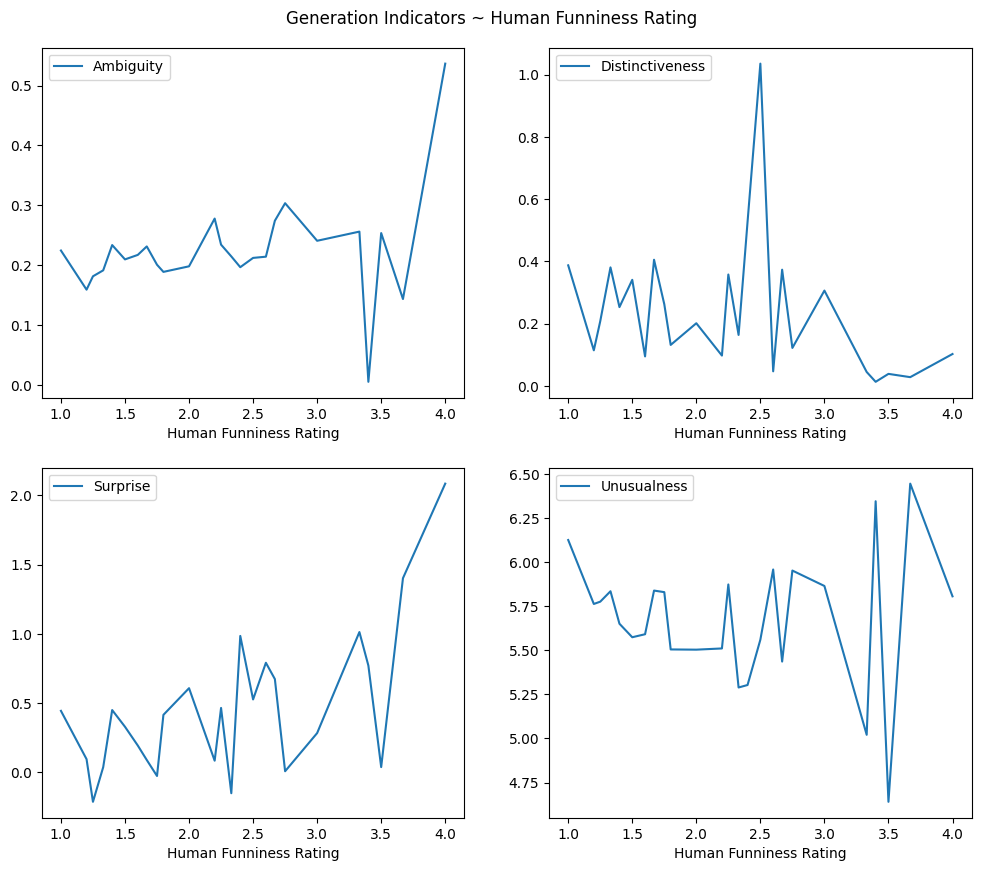

In [17]:
indicators = r'./results/pun_generation_detailed_indicators.json'
indicators = load_json_file(indicators)
plot_indicators_with_humor(dataset=dict(**hom_punDataset,**het_punDataset), indicators=indicators, save=True)